# ПЛАН 
# Предсказание оттока клиентов оператора связи «Ниединогоразрыва.ком»

**Цель проекта**

Проанализировать данные по поведению клиентов оператора связи «Ниединогоразрыва.ком» и разработать модель машинного обучения, способную прогнозировать отток клиентов с высокими значениями метрик качества. Прогнозные данные будут использованы для того, чтобы разработать стратегию удержания действующих клиентов, предлагая промокоды и специальные условия пользователям, склонным к оттоку.

**Данные для анализа**

На анализ переданы исторические данные о поведении клиентов и использовании ими услуг связи (персональные данные, информация о тарифах и договорах клиентов). Данные актуальны на 1 февраля 2020.

**Шаги (план) проекта**

1. Загрузка данных: загрузим все предоставленные файлы (4 шт) и изучим их содержание

2. Исследование данных: изучим данные, чтобы определить, есть ли в них целевой признак, и какие признаки следует использовать для обучения модели

3. Подготовка данных для обучения и тестирования моделей: подготовим данные для обучения моделей Логистической регрессии, Случайного леса и LGBM с использованием F1_score, accuracy и AUC-ROC как метрик качества 

4. Обучение и тестирование моделей и выбор оптимальной модели: обучим модели и выберем лучшую с помощью кросс-валидациии

5. Проверка результатов модели на тестовой выборке: проверим метрики качества модели на тестовой выборке и посмотрим на важность признаков

6. Общий вывод: сделаем вывод о рекомендуемой модели для использования заказчиком


## Загрузка данных

Импортируем необходимые библиотеки и утилиты для работы с данными в текущем проекте.

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install -c glemaitre imbalanced-learn

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.2
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
# импорт библиотек
import datetime as dt
import numpy as np
import pandas as pd

# построение диаграмм
import matplotlib.pyplot as plt
import seaborn as sns

# оценка мультиколлинеарности признаков
import phik
from phik.report import plot_correlation_matrix
from phik import report

# машинное обучение
from imblearn.over_sampling import SMOTE
import lightgbm as ltb
from numpy.random import RandomState
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# оценка качества модели
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

# отключение предупреждений
import warnings
warnings.filterwarnings("ignore")

Откроем предоставленные файлы и изучим данные.

**Файл personal.csv**

In [4]:
# открытие файла personal.csv
try:
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
except FileNotFoundError:
    df_personal = pd.read_csv('C:/Users/User/Desktop/Обучение/personal.csv')
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
# получение общей информации о структуре данных
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Файл contract.csv**

In [6]:
# открытие файла contract.csv
try:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
except FileNotFoundError:
    df_contract = pd.read_csv('C:/Users/User/Desktop/Обучение/contract.csv')
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [7]:
# получение общей информации о структуре данных
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


**Файл phone.csv**

In [8]:
# открытие файла phone.csv
try:
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
except FileNotFoundError:
    df_phone = pd.read_csv('C:/Users/User/Desktop/Обучение/phone.csv')
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [9]:
# получение общей информации о структуре данных
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Файл internet.csv**

In [10]:
# открытие файла internet.csv
try:
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
except FileNotFoundError:
    df_internet = pd.read_csv('C:/Users/User/Desktop/Обучение/internet.csv')
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [11]:
# получение общей информации о структуре данных
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


<div style="border:solid blue 2px; padding: 20px">
    
**Вывод** 
  
В ходе обработки выборки на данном этапе проделаны следующие работы:
    
1. Загружены и изучены предоставленные 4 файла с данными.
2. Сделаны общие выводы: 
 * файлы с данными о пользователях и договорах содержат равное количество строк без пропусков (7042 строки), файл с данными о телефонии содержит 6360 строк, файл с данными о пользовании интернетом - 5516 строк,
 * для последующей работы потребуется объединить данные по customerID, исправить наименования колонок и типы данных, проверить данные на дубликаты и уникальность, обработать образовавшиеся в результате объединения строки с пропусками, провести кодирование качественных признаков с помощью техники OHE, 
 * в качестве целевого признака для обучения модели будем использовать данные колонки EndDate файла contract.csv, преобразовав их в двоичный код (0 или 1), в качестве признаков используем все предоставленные данные, кроме колонок SeniorCitizen (файл personal.csv) и PaperlessBilling файл (contract.csv), также добавим в набор признаков расчетную колонку со временем обслуживания клиента в компании (BeginDate минус EndDate) как релевантную для прогнозирования оттока.

   
<div>

Вопросы:
1. Зачем в архиве с исходными файлами даны файлы ._personal и ._phone?
2. Можно ли как-то оценить корреляцию между качественными признаками и целевым признаком?
3. Подойдут ли для задачи выбранные модели и метрики качества?
4. Если метрики качества выбраны верно, к каким значениям нужно стремиться? Понятно, что к максимально возможному, и все же?

# ПРОЕКТ 
# Предсказание оттока клиентов оператора связи «Ниединогоразрыва.ком»

## Исследование данных

Объединим файлы, обработаем пропуски, исправим типы данных, проверим данные на дубликаты, добавим признак с длительностью обслуживания клиентов и оценим корреляцию и мультиколлинеарность признаков, чтобы определить те, которые следует использовать для обучения моделей. 

**Объединим файлы**, чтобы получить один общий датасет.

In [12]:
# объединение таблиц и вывод первых 5 строк объединенной таблицы
df = df_personal.set_index('customerID').join(df_contract.set_index('customerID'))
df = df.join(df_phone.set_index('customerID'))
df = df.join(df_internet.set_index('customerID'))
df.head()

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,DSL,No,Yes,No,No,No,No
5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No


Проверим результат.

In [13]:
# вывод общей информации о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   BeginDate         7043 non-null   object 
 5   EndDate           7043 non-null   object 
 6   Type              7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7043 non-null   object 
 11  MultipleLines     6361 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null 

Объединение проведено корректно, в итоговый файл вошли все строки по клиентам (7042). Поскольку названия столбцов читабельные, не будем их переименовывать. 

**Обработаем пропуски**: проверим, какие варианты заполнения использованы в колонках с меньшим числом ячеек, чтобы принять решение о способе обработки пропусков.

In [14]:
# проверка заполнения колонки 'MultipleLines'
df['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

In [15]:
# проверка заполнения колонки 'InternetService'
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [16]:
# проверка заполнения колонки 'OnlineSecurity'
df['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

In [17]:
# проверка заполнения колонки 'OnlineBackup'
df['OnlineBackup'].value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

In [18]:
# проверка заполнения колонки 'DeviceProtection'
df['DeviceProtection'].value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

In [19]:
# проверка заполнения колонки 'TechSupport'
df['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

In [20]:
# проверка заполнения колонки 'StreamingTV'
df['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

In [21]:
# проверка заполнения колонки 'StreamingMovies'
df['StreamingMovies'].value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

Вероятнее всего, пропуски связаны с тем, что часть клиентов, не вошедших в файлы с данными об использовании специальных услуг телефонии и интернета, ими не пользуются. Соответственно, заменим пропуски на значение No.

In [22]:
# замена всех пропусков на значение "No"
df = df.fillna('No')

Проверим результат.

In [23]:
# вывод общей информации о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   BeginDate         7043 non-null   object 
 5   EndDate           7043 non-null   object 
 6   Type              7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7043 non-null   object 
 11  MultipleLines     7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null 

Замена проведена корректно, пропусков более нет.

Выведем первые пять строк таблицы.

In [24]:
# вывод первых пяти строк таблицы
df.head()

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,DSL,No,Yes,No,No,No,No
5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No


**Изменим типы данных** в колонках SeniorCitizen, BeginDate, EndDate, TotalCharges.

In [25]:
# изменение типа данных в колонке SeniorCitizen на category
df['SeniorCitizen']= df['SeniorCitizen'].astype('category')

In [26]:
# изменение типа данных в колонке BeginDate на datetime
df['BeginDate'] = pd.to_datetime(df['BeginDate'], errors = 'coerce')

In [27]:
# изменение типа данных в колонке EndDate на datetime
df['EndDate'] = pd.to_datetime(df['EndDate'], errors = 'coerce')

In [28]:
# изменение типа данных в колонке TotalCharges на float64
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

Проверим результат.

In [29]:
# вывод общей информации о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7043 non-null   object        
 1   SeniorCitizen     7043 non-null   category      
 2   Partner           7043 non-null   object        
 3   Dependents        7043 non-null   object        
 4   BeginDate         7043 non-null   datetime64[ns]
 5   EndDate           1869 non-null   datetime64[ns]
 6   Type              7043 non-null   object        
 7   PaperlessBilling  7043 non-null   object        
 8   PaymentMethod     7043 non-null   object        
 9   MonthlyCharges    7043 non-null   float64       
 10  TotalCharges      7032 non-null   float64       
 11  MultipleLines     7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup  

In [30]:
# вывод первых пяти строк таблицы
df.head()

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,No,DSL,No,Yes,No,No,No,No
5575-GNVDE,Male,0,No,No,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,Male,0,No,No,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,No,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No


Замена типов данных проведена корректно.

**Проверим наличие в данных полных дубликатов**.

In [31]:
# подстчет строк - явных дубликатов
df.duplicated().sum()

13

Удалим явные дубликаты.

In [32]:
# удаление дубликатов
df = df.drop_duplicates()

Проверим результат.

In [33]:
# подсчет строк - явных дубликатов
df.duplicated().sum()

0

Дубликаты успешно удалены.

Продублируем колонку EndDate и сформируем из нее колонку с целевым признаком Churn, где 0 означает, что клиент все еще обслуживается в компании, и 1 - что он перестал пользоваться услугами и расторг договор.

In [34]:
# создание колонки Churn с целевым признаком
df['Churn'] = df['EndDate']

In [35]:
# присвоение пустым ячейкам значения "0" (еще обслуживаются)
df['Churn'] = df['Churn'].fillna(0) 

In [36]:
# присвоение непустым ячейкам значения "1" (уже не обслуживаются)
df.loc[df['Churn'] != 0, 'Churn'] = 1

In [37]:
# изменение типа данных в колонке Churn на int
df['Churn']= df['Churn'].astype('int64')

Проверим результат.

In [38]:
# вывод первых 5 строк
df.head()

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,No,DSL,No,Yes,No,No,No,No,0
5575-GNVDE,Male,0,No,No,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,No,DSL,Yes,No,Yes,No,No,No,0
3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No,1
7795-CFOCW,Male,0,No,No,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,No,DSL,Yes,No,Yes,Yes,No,No,0
9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No,1


**Рассчитаем продолжительность обслуживания клиентов в днях** и добавим колонку с этим признаком DaysOfService в датасет. Для корректного расчета заменим отсутствующие значения в колонке EndDate датой, на которую актуальны данные - 01.02.2020.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7030 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7030 non-null   object        
 1   SeniorCitizen     7030 non-null   category      
 2   Partner           7030 non-null   object        
 3   Dependents        7030 non-null   object        
 4   BeginDate         7030 non-null   datetime64[ns]
 5   EndDate           1866 non-null   datetime64[ns]
 6   Type              7030 non-null   object        
 7   PaperlessBilling  7030 non-null   object        
 8   PaymentMethod     7030 non-null   object        
 9   MonthlyCharges    7030 non-null   float64       
 10  TotalCharges      7019 non-null   float64       
 11  MultipleLines     7030 non-null   object        
 12  InternetService   7030 non-null   object        
 13  OnlineSecurity    7030 non-null   object        
 14  OnlineBackup  

In [40]:
# замена отсутствующих значений в колонке EndDate на 01.02.2020
df['EndDate'] = df['EndDate'].fillna('2020-02-01') 

In [41]:
# расчет количества дней обслуживания клиентов в днях
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['DaysOfService'] = (df['EndDate'] - df['BeginDate']).dt.days
df['DaysOfService'].head()

customerID
7590-VHVEG      31
5575-GNVDE    1036
3668-QPYBK      61
7795-CFOCW    1371
9237-HQITU      61
Name: DaysOfService, dtype: int64

**Удалим колонки BeginDate и EndDate**, поскольку сами по себе они неинформативны, и проверим результат.

In [42]:
# удаление колонок
df = df.drop(['EndDate', 'BeginDate'], axis=1)

In [43]:
# вывод первых пяти строк таблицы
df.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn,DaysOfService
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,DSL,No,Yes,No,No,No,No,0,31
5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,No,DSL,Yes,No,Yes,No,No,No,0,1036
3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No,1,61
7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,DSL,Yes,No,Yes,Yes,No,No,0,1371
9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No,1,61


Добавление нового признака и целевого признака, а также удаление неинформативных колонок проведены корректно.

**Оценим мультиколлинеарность** признаков в датасете, воспользовавшись библиотекой phik.

In [44]:
# вывод матрицы взаимозависимостей признаков
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Churn', 'DaysOfService']


,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Churn,DaysOfService
gender,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00
SeniorCitizen,0.00,1.00,0.02,0.33,0.09,0.24,0.29,0.30,0.15,0.22,0.16,0.06,0.10,0.09,0.09,0.16,0.19,0.23,0.03
Partner,0.00,0.02,1.00,0.65,0.18,0.02,0.24,0.20,0.42,0.22,0.00,0.22,0.22,0.24,0.18,0.19,0.18,0.23,0.49
Dependents,0.00,0.33,0.65,1.00,0.15,0.17,0.23,0.19,0.12,0.03,0.11,0.12,0.03,0.01,0.10,0.02,0.06,0.25,0.21
Type,0.00,0.09,0.18,0.15,1.00,0.11,0.28,0.39,0.51,0.06,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.25,0.66
PaperlessBilling,0.00,0.24,0.02,0.17,0.11,1.00,0.37,0.47,0.20,0.25,0.23,0.00,0.20,0.16,0.05,0.34,0.32,0.29,0.00
PaymentMethod,0.00,0.29,0.24,0.23,0.28,0.37,1.00,0.40,0.35,0.34,0.32,0.26,0.28,0.30,0.27,0.38,0.38,0.45,0.37
MonthlyCharges,0.01,0.30,0.20,0.19,0.39,0.47,0.40,1.00,0.76,0.68,0.92,0.55,0.63,0.67,0.58,0.83,0.83,0.36,0.41
TotalCharges,0.00,0.15,0.42,0.12,0.51,0.20,0.35,0.76,1.00,0.61,0.51,0.54,0.66,0.67,0.57,0.66,0.67,0.28,0.84
MultipleLines,0.00,0.22,0.22,0.03,0.06,0.25,0.34,0.68,0.61,1.00,0.23,0.15,0.31,0.31,0.15,0.39,0.39,0.06,0.43


Визуализируем матрицу взаимозависимостей.

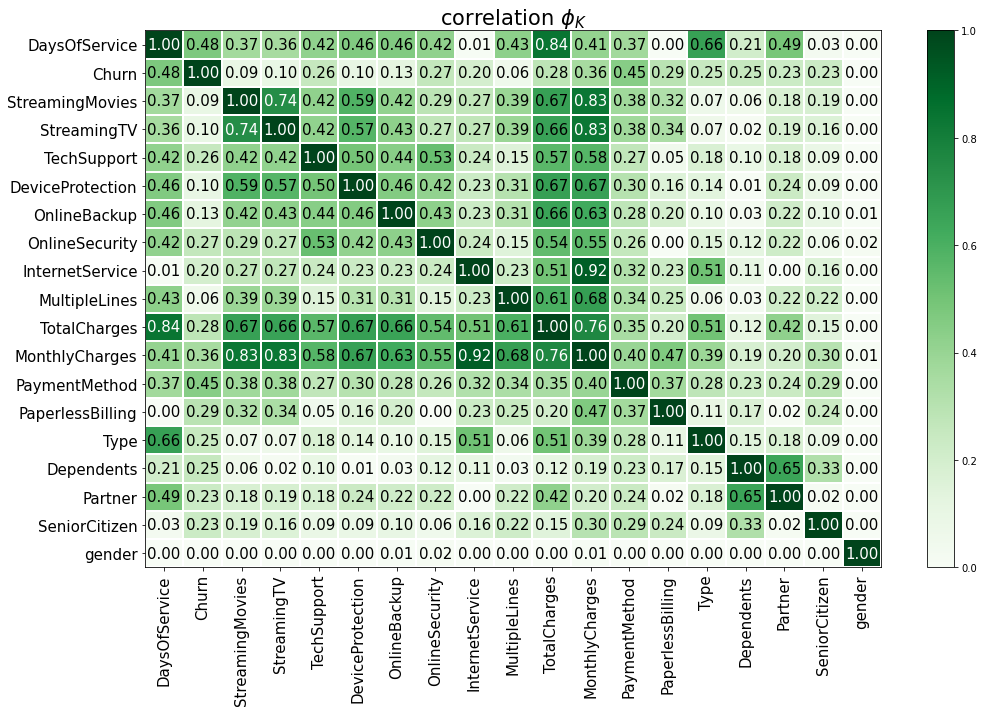

In [45]:
# построение hitmap по взаимозависимостям признаков
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 10))
plt.tight_layout()

На основании данных о взаимозависимостях удалим колонки с очень слабой корреляцией с целевым признаком (<0.15):
gender, MultipleLines, DeviceProtection, StreamingTV, StreamingMovies, OnlineBackup.

Удалим также один из пары признаков, очень сильно связанных друг с другом (>=0.75):
удалим TotalCharges, оставим DaysOfService; удалим InternetService, оставим MonthlyCharges.

In [46]:
# удаление признаков из датасета
df = df.drop(['gender', 
              'MultipleLines', 
              'DeviceProtection', 
              'StreamingTV', 
              'StreamingMovies', 
              'OnlineBackup', 
              'TotalCharges', 
              'InternetService'], axis=1)

Оценим результат.

In [47]:
# вывод первых пяти строк таблицы
df.head()

,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,OnlineSecurity,TechSupport,Churn,DaysOfService
customerID,,,,,,,,,,,
7590-VHVEG,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,No,No,0,31
5575-GNVDE,0,No,No,One year,No,Mailed check,56.95,Yes,No,0,1036
3668-QPYBK,0,No,No,Month-to-month,Yes,Mailed check,53.85,Yes,No,1,61
7795-CFOCW,0,No,No,One year,No,Bank transfer (automatic),42.30,Yes,Yes,0,1371
9237-HQITU,0,No,No,Month-to-month,Yes,Electronic check,70.70,No,No,1,61


Удаление проведено корректно, в датасете остались столбцы с необходимыми признаками.

**Визуализируем распределения** в оставшихся для обучения признаках.

Признак **SeniorCitizen**

<AxesSubplot:xlabel='SeniorCitizen', ylabel='Churn'>

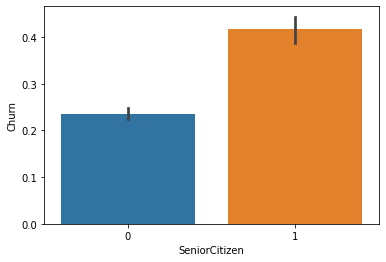

In [48]:
# построение диаграммы
sns.barplot(x="SeniorCitizen", y="Churn", data=df)

40% пенсионеров и 22% непенсионеров отказались от услуг компании.

Признак **Partner**

<AxesSubplot:xlabel='Partner', ylabel='Churn'>

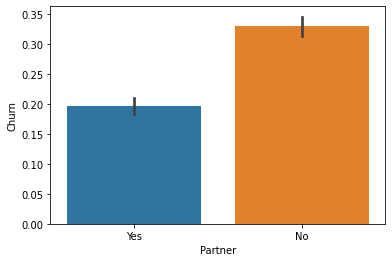

In [49]:
# построение диаграммы
sns.barplot(x="Partner", y="Churn", data=df)

33% клиентов не в браке и 20% людей в браке отказались от услуг компании.

Признак **Dependents**

<AxesSubplot:xlabel='Dependents', ylabel='Churn'>

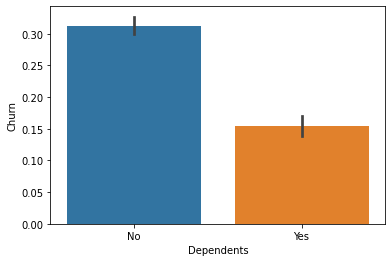

In [50]:
# построение диаграммы
sns.barplot(x="Dependents", y="Churn", data=df)

30% клиентов без иждивенцев и 15% клиентов с иждивенцами отказались от услуг компании.

Признак **Type**

<AxesSubplot:xlabel='Type', ylabel='Churn'>

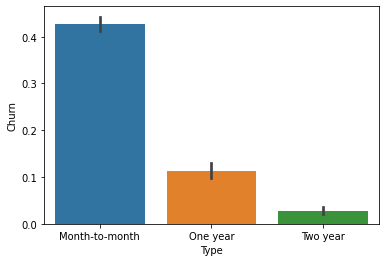

In [51]:
# построение диаграммы
sns.barplot(x="Type", y="Churn", data=df)

45% клиентов, оплачивавших услуги ежемесячно, 10% клиентов с оплатой за год и 0.3% клиентов с оплатой за два года отказались от услуг компании.

Признак **PaperlessBilling**

<AxesSubplot:xlabel='PaperlessBilling', ylabel='Churn'>

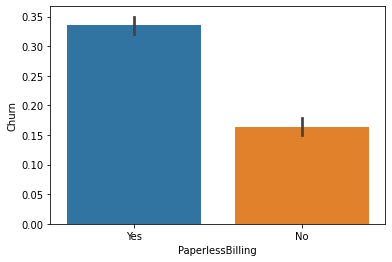

In [52]:
# построение диаграммы
sns.barplot(x="PaperlessBilling", y="Churn", data=df)

33% клиентов, получавших счета за услуги на электронную почту, и 15% клиентов, получавших счета на бумажном носителе, отказались от услуг компании.

Признак **PaymentMethod**

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Electronic check'),
  Text(1, 0, 'Mailed check'),
  Text(2, 0, 'Bank transfer (automatic)'),
  Text(3, 0, 'Credit card (automatic)')])

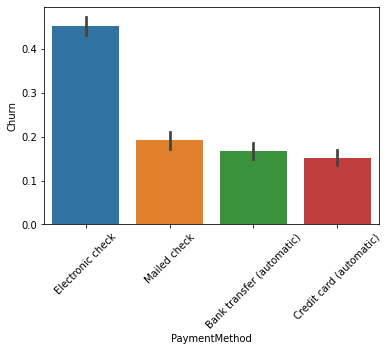

In [53]:
# построение диаграммы 
sns.barplot(x="PaymentMethod", y="Churn", data=df)
plt.xticks(rotation = 45)

45% клиентов, оплачивавших счета электронно, 20% клиентов, оплачивавших счета отправкой чека по почте, 18% клиентов, оплачивавших счета автоматическим списанием с банковского счета, и 17% клиентов, оплачивавших счета автоматическими списаниями с карты, отказались от услуг компании.

Признак **MonthlyCharges**

Для оценки распределения месячных затрат на услуги среди клиентов, отказавшихся от услуг компании, сделаем срез данных по условию Churn == 1.

In [54]:
# отбор клиентов, отказавшихся от услуг компании
df_churn = df.query('Churn == 1')

<AxesSubplot:>

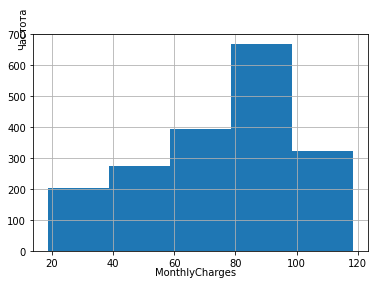

In [55]:
# построение гистограммы
fig, axes = plt.subplots(sharex=True, sharey=True)
fig.text(0.5, 0.04, 'MonthlyCharges', ha='center')
fig.text(0.09, 0.9, 'Частота', va='center', rotation='vertical')
df_churn['MonthlyCharges'].hist(bins=5)

Ежемесячные расходы на связь у ушедших клиентов распределены между 20 и 120 долларами. Максимальное число клиентов расходовало в месяц 80-100 долларов.

Признак **OnlineSecurity**

<AxesSubplot:xlabel='OnlineSecurity', ylabel='Churn'>

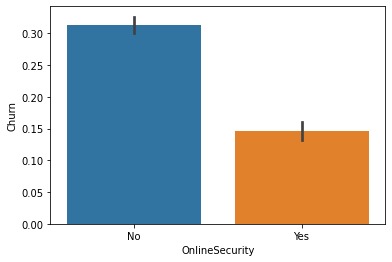

In [56]:
# построение диаграммы 
sns.barplot(x="OnlineSecurity", y="Churn", data=df)

31% клиентов, не пользовавшихся услугой блокировки небезопасных сайтов, и 15% пользовавшихся этой услугой, отказались от услуг компании.

Признак **TechSupport**

<AxesSubplot:xlabel='TechSupport', ylabel='Churn'>

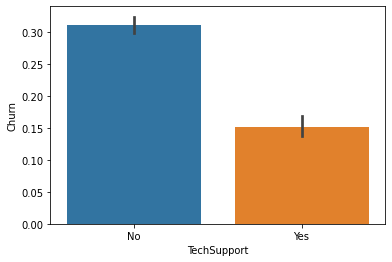

In [57]:
# построение диаграммы 
sns.barplot(x="TechSupport", y="Churn", data=df)

32% клиентов, не пользовавшихся услугами технической поддержки, и 15% пользовавшихся, отказались от услуг компании.

Признак **DaysOfService**

<AxesSubplot:>

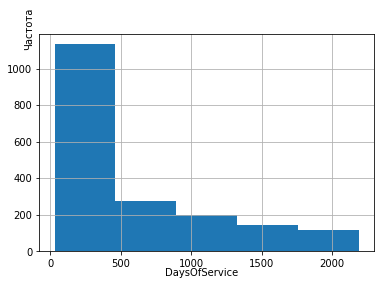

In [58]:
# построение гистограммы
fig, axes = plt.subplots(sharex=True, sharey=True)
fig.text(0.5, 0.04, 'DaysOfService', ha='center')
fig.text(0.09, 0.9, 'Частота', va='center', rotation='vertical')
df_churn['DaysOfService'].hist(bins=5)

Количество дней обслуживая у ушедших клиентов распределено в диапазоне 10-2100 дней, максимальное число клиентов ушло после обслуживания в течение первых 480 дней (в течение первого года-полутора).

## Подготовка данных для обучения и тестирования моделей

Разделим выборку и подготовим данные для обучения моделей: обработаем качественные признаки техникой OHE, сбалансируем классы в обучающей выборке, проведем стандартизацию количественных признаков.

Зададим random_state = 190922

In [59]:
# фиксирование random_state
state = np.random.RandomState(190922)

**Разделим выборку на обучающую и тестовую**.

In [60]:
# разделение признаков и целевого признака на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    df.drop(['Churn'], axis=1), df['Churn'], test_size=0.25, random_state = state 
)

Оценим размер получившихся выборок.

In [61]:
# вывод размера выборки
features_train.shape

(5272, 10)

In [62]:
# вывод размера выборки
features_test.shape

(1758, 10)

In [63]:
# вывод размера выборки
target_train.shape

(5272,)

In [64]:
# вывод размера выборки
target_test.shape

(1758,)

Разделение проведено корректно.

**Преобразуем качественные признаки техникой OHE** в обучающей и тестовой выборках, чтобы использовать их для обучения и тестирования моделей.

In [65]:
# преобразование категориальных признаков в обучающей выборке
features_train = pd.get_dummies(features_train, drop_first = True)

In [66]:
# проверка порядка колонок
features_train.head()

,MonthlyCharges,DaysOfService,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_Yes,TechSupport_Yes
customerID,,,,,,,,,,,,,
0219-QAERP,19.80,914,0,1,0,1,0,0,1,0,0,0,0
1543-LLLFT,98.30,1857,1,1,0,1,0,1,0,0,1,0,1
3378-AJRAO,24.85,1340,0,1,1,1,0,0,0,1,0,0,0
6828-HMKWP,21.05,365,0,1,1,0,1,0,0,0,0,0,0
3292-PBZEJ,111.40,337,1,0,0,0,0,1,0,1,0,0,1


In [67]:
# преобразование категориальных признаков в тестовой выборке
features_test = pd.get_dummies(features_test, drop_first = True)

In [68]:
# проверка порядка колонок
features_test.head()

,MonthlyCharges,DaysOfService,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_Yes,TechSupport_Yes
customerID,,,,,,,,,,,,,
8756-RDDLT,44.95,2071,0,0,0,0,0,0,0,1,0,0,1
9396-ZSFLL,48.85,457,0,0,0,0,0,0,0,0,1,0,0
2710-WYVXG,71.10,92,0,0,0,0,1,0,0,0,1,1,1
6161-UUUTA,79.90,92,1,0,0,0,0,1,0,1,0,0,0
2040-OBMLJ,81.70,945,0,0,0,1,0,0,1,0,0,0,1


Поскольку в признаках присутствуют количественные признаки с разными разбросами значений (колонки MonthlyCharges и DaysOfService), во избежание присвоения бОльшего веса признакам с бОльшими значениями и разбросом **приведем признаки к одному масштабу с помощью стандартизации данных**.

In [69]:
# код от предупреждения SettingWithCopy
pd.options.mode.chained_assignment = None
# формирование списка стобцов и создание структуры для стандартизации
numeric=['MonthlyCharges', 'DaysOfService']
scaler = StandardScaler()
# настройка стандартизации на обучающих данных
scaler.fit(features_train[numeric]) 
# стандартизация выборок для обучения и тестирования
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Проверим результат.

In [70]:
# вывод первых 5 строк выборки
features_train.head()

,MonthlyCharges,DaysOfService,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_Yes,TechSupport_Yes
customerID,,,,,,,,,,,,,
0219-QAERP,-1.502120,-0.084203,0,1,0,1,0,0,1,0,0,0,0
1543-LLLFT,1.107253,1.178140,1,1,0,1,0,1,0,0,1,0,1
3378-AJRAO,-1.334256,0.486060,0,1,1,1,0,0,0,1,0,0,0
6828-HMKWP,-1.460569,-0.819120,0,1,1,0,1,0,0,0,0,0,0
3292-PBZEJ,1.542703,-0.856602,1,0,0,0,0,1,0,1,0,0,1


In [71]:
# вывод первых 5 строк выборки
features_test.head()

,MonthlyCharges,DaysOfService,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_Yes,TechSupport_Yes
customerID,,,,,,,,,,,,,
8756-RDDLT,-0.666123,1.464610,0,0,0,0,0,0,0,1,0,0,1
9396-ZSFLL,-0.536485,-0.695965,0,0,0,0,0,0,0,0,1,0,0
2710-WYVXG,0.203114,-1.184570,0,0,0,0,1,0,0,0,1,1,1
6161-UUUTA,0.495630,-1.184570,1,0,0,0,0,1,0,1,0,0,0
2040-OBMLJ,0.555462,-0.042705,0,0,0,1,0,0,1,0,0,0,1


Проверим сбалансированность классов в обучающей выборке, поскольку для корректного результата важно проводить обучение на сбалансированном датасете.

In [72]:
# вывод соотношения классов в колонке Churn
class_frequency = target_train.value_counts(normalize=True).round(3)
display(class_frequency)

0    0.732
1    0.268
Name: Churn, dtype: float64

Выборка несбалансирована, количество ушедших клиентов почти в 3 раза меньше количества оставшихся клиентов.
Визуализируем дисбаланс.

<AxesSubplot:title={'center':'Частота классов'}, xlabel='Класс', ylabel='Частота, %'>

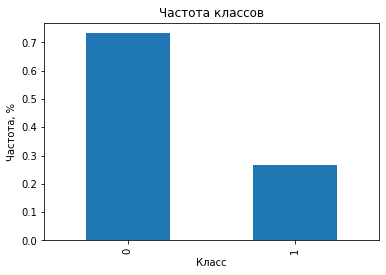

In [73]:
# построение диаграммы с частотой классов
class_frequency.plot(kind='bar', xlabel='Класс', ylabel='Частота, %', title='Частота классов')

Для обучения моделей необходимо скорректировать несбалансированность выборки с помощью метода SMOTE.

In [74]:
# балансировка выборки с помощью SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(features_train, target_train)

In [75]:
# проверка размера сбалансированной выборки признаков
X_resampled.shape

(7718, 13)

In [76]:
# проверка размера сбалансированной выборки с целевым признаком
y_resampled.shape

(7718,)

Проверим результат балансировки.

In [77]:
# вывод соотношения классов в колонке Churn
class_frequency = y_resampled.value_counts(normalize=True).round(3)
display(class_frequency)

0    0.5
1    0.5
Name: Churn, dtype: float64

Балансировка проведена корректно.

## Обучение и тестирование моделей и выбор оптимальной модели

Обучим и протестируем три модели (Логистической регрессии, Случайного леса и LGBM) с помощью кросс-валидации для выбора модели с наилучшими результатами на основании оценки метрики AUC-ROC.

In [78]:
# создание оценщика на основе AUC-ROC
# AUCROC = make_scorer(roc_auc_score)

**Логистическая регрессия**

In [79]:
# создание модели
model_reg = LogisticRegression(random_state=state, solver='lbfgs')

In [80]:
# обучение модели и оценка AUC-ROC на обучающей выборке с помощью кросс-валидации
result_train_reg = cross_val_score (model_reg, X_resampled, y_resampled, cv=5, scoring='roc_auc').mean()
print("Логистическая регрессия_AUC-ROC на обучающей выборке:", result_train_reg)

Логистическая регрессия_AUC-ROC на обучающей выборке: 0.8496428759706255


**Случайный лес**

In [81]:
# подбор параметров с помощью GridSearchCV (код закомментирован, т.к. подбор параметров сильно грузит ноутбук)
#clf = RandomForestClassifier(random_state=state)
#parameters = {'n_estimators': range (10, 101, 10),
              #'max_depth': range (5, 21, 2)}
#grid = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc', n_jobs=-1)
#grid.fit(X_resampled, y_resampled)
#grid.best_params_

In [82]:
# вывод наилучшего результата метрики AUC-ROC
#grid.best_score_

In [83]:
# сознание модели с подобранными GridSearchCV параметрами
model_forest = RandomForestClassifier(random_state=state, max_depth=19, n_estimators=100)

**LGBM**

In [84]:
# подбор параметров с помощью GridSearchCV (код закомментирован, т.к. подбор параметров сильно грузит ноутбук)
#clf = ltb.LGBMClassifier(random_state=state)
#parameters = {
    #'max_depth': range (2, 100, 2),
    #'n_estimators': range (10, 201, 20),
    #'num_leaves': range (2, 51, 10),
    #}
#grid = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc', n_jobs=-1)
#grid.fit(X_resampled, y_resampled)
#grid.best_params_

In [85]:
# вывод наилучшего результата метрики AUC-ROC
#grid.best_score_

In [86]:
# сознание модели с подобранными GridSearchCV параметрами
model_LGBM = ltb.LGBMClassifier(random_state=state, max_depth=38, n_estimators=190, num_leaves=42)

Наилучшие результаты по метрике AUC-ROC на обучающей выборке показала модель LGBM (0.96). Проверим ее результаты на тестовой выборке.

## Проверка результатов модели на тестовой выборке

Проверим результаты модели на тестовой выборке с помощью целевой метрики AUC-ROC, а также дополнительных метрик качества f1-score и accuracy.

Обучим выбранную модель.

In [95]:
# обучение модели
model_LGBM.fit(X_resampled, y_resampled)

LGBMClassifier(max_depth=38, n_estimators=190, num_leaves=42,
               random_state=RandomState(MT19937) at 0x7F042E32A340)

In [88]:
# предсказание целевого признака с помощью модели
#predict_test_LGBM = model_LGBM.predict(features_test)

Вычислим вероятности положительных классов.

In [89]:
# вычисление вероятностей классов
probabilities_test = model_LGBM.predict_proba(features_test)

In [90]:
# формирование Series с вероятностями только положительного класса
probabilities_one_test = probabilities_test[:, 1]
probabilities_one_test

array([0.11220629, 0.18722262, 0.00472477, ..., 0.2706629 , 0.21479469,
       0.0341226 ])

Рассчитаем значение целевой метрики **AUC-ROC**.

In [91]:
# вывод целевой метрики AUC-ROC на тестовой выборке
print('LGBM_AUC-ROC на тестовой выборке:', roc_auc_score(target_test, probabilities_one_test))

LGBM_AUC-ROC на тестовой выборке: 0.9126944254142246


Рассчитаем значение метрики качества **f1-score**.

In [92]:
predicted_test = model_LGBM.predict(features_test)

In [93]:
print('LGBM_f1-score на тестовой выборке:', f1_score(target_test, predicted_test))

LGBM_f1-score на тестовой выборке: 0.7260726072607262


Рассчитаем значение метрики качества **accuracy**.

In [94]:
print('LGBM_accuracy на тестовой выборке:', accuracy_score(target_test, predicted_test))

LGBM_accuracy на тестовой выборке: 0.8583617747440273


## Общий вывод

Подведем итоги проведенного исследования.

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод** 
  
В ходе проект проделаны следующие работы:
    
1. Загружены и изучены предоставленные 4 файла с данными.
2. Для дальнейшей работы файлы объединены, заполнены пропуски и изменены типы данных там, где это было необходимо.
3. Удалены полные дубликаты.
4. Сформирован столбец с целевым признаком.
5. Добавлен столбец с признаком о количестве дней обслуживания и удалены неинформативные признаки.
6. Проведена оценка мультиколлинеарности признаков, удалены дублирующие признаки и признаки, слабо коррелирующие с целевым признаком.
7. Выборка разделена на обучающую и тестовую, данные обработаны: произведено кодирование качественных признаков техникой OHE, стандартизация количественных признаков и балансировка классов техникой SMOTE в обучающей выборке.
8. Проведено обучение моделей Логистической регрессии, Случайного леса и LGBM на обучающей выборке. 
9. Выбрана модель с наилучшим результатом по целевой метрике AUC-ROC - модель LGBM.
10. Модель протестирована на тестовой выборке. Получены значения метрик качества: AUC-ROC - 0.91, f1-score - 0.72, accuracy - 0.85.
Значение целевой метрики AUC-ROC достигнуто, модель может быть рекомендована к использованию. 

   
<div>

# ОТЧЕТ

Отчет (ответы на 4 вопроса)
1. Совпало ли итоговое решение с планом и почему
  Не совсем совпало, изначальный план и комментарии по пунктам:
  1. Загрузка данных: загрузим все предоставленные файлы (4 шт) и изучим их содержание
Сделано в соответствии с планом
  2. Исследование данных: изучим данные, чтобы определить, есть ли в них целевой признак, и какие признаки следует использовать для обучения модели
Сформулировано очень обще, по факту было объединение данных, предобработка (пропуски, типы данных, дубликаты, добавление целевого признака, добавление признака с количеством дней обслуживания, удаление признаков с датами, оценка мультиколлинеарности и удаление лишних признаков, визуализация распределений и изучение оставшихся признаков).
Работы оказалось больше, чем я предполагала. 
  3. Подготовка данных для обучения и тестирования моделей: подготовим данные для обучения моделей Логистической регрессии, Случайного леса и LGBM с использованием F1_score, accuracy и AUC-ROC как метрик качества 
Сделано в соответствии с планом: проведено разделение на выборки, обработка качественных признаков (искренне считала по итогам работы в тренажере, что get_dummies - это и есть OHE, но по комментарию ревьюера поняла, что нет, буду изучать самостоятельно; также в новинку была обработка после разделения, а также тот факт, что выборки признаков надо перепроверить, чтобы не были перепутаны местами колонки, т.к. get_dummies имеет такую побочку), стандартизация и балансировка новым для меня SMOTE.
  4. Обучение и тестирование моделей и выбор оптимальной модели: обучим модели и выберем лучшую с помощью кросс-валидации
Сделано в соответсвии с планом; открыла для себя, что GridSearch содержит кросс-валидацию, и отдельно ее после подбора параметров делать не надо.
  5. Проверка результатов модели на тестовой выборке: проверим метрики качества модели на тестовой выборке и посмотрим на важность признаков
Модель проверена на тестовой выборке в соответствии с планом, а важность признаков я оценивала раньше, на шаге 2; на последнем шаге это делать нелогично.
  6. Общий вывод: сделаем вывод о рекомендуемой модели для использования заказчиком
Сделала, модель рекомендую.

2. Какие затруднения были, и как их решили
  Немного запуталась с обработкой ошибок при изменении типа данных на дату (ячейки с пропусками), пришлось поднимать конспекты.
  Также немного сбил тип данных в ячейке с целевым признаком: сначала сделала его category, потом исправила на int, т.к. с category не строилась диаграмма при анализе признаков (какой % с тем или иным признаком ушел в отток).
  Про Phik и SMOTE пришлось почитать, благо, статьи содержали куски кода, который можно было позаимствовать)
  Основная сложность, конечно, оказалась с достижением целевого значения метрики качества. Жаль, так и не попробовала модель CatBoost. Сокурсники писали, что она дает отличные результаты почти сразу. Но я побоялась, что мой ноут не потянет подбор параметров для нее, он у меня и на GridSearch для LGBM серьезно зависает.

3. Какие были ключевые шаги решения? Какие признаки вошли в итоговую модель и почему? Как предобрабатывали эти данные?
  В целом, шаги были определены в общем виде в плане, их я и старалась придерживаться:
  1. Загрузить и изучить данные.
  2. Провести предобработку и очистку от лишних признаков.
  3. Подготовить данные для обучения.
  4. Подобрать параметры и обучить 3 модели, выбрать лучшую.
  5. Проверить ее на тестовых данных.
  6. Сделать вывод.
  В итоговую модель вошли признаки с существенной корреляцией с целевым признаком (>0.15). Признаки, имеющие высокую (>=0.75) корреляцию с другим признаком, были удалены  в рамках борьбы с мультиколлинеарностью.
  Оставшиеся признаки вошли в модель: SeniorCitizen, Partner, Dependents, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, OnlineSecurity, TechSupport, DaysOfService.
  Для обучения качественные признаки я обработала с помощью get_dummies, количественные - с помощью standard_scaler, дополнительно сбалансировала обучающую выборку с помощью SMOTE.

4. Описываем итоговую модель с ее гиперпараметрами, включая random state.
Модель с наилучшими результатами на обучающей выборке (AUC-ROC 0.96) - модель LGBM.
Параметры модели: random_state=190922, max_depth=38, n_estimators=190, num_leaves=42 (больше параметров брать не стала из опасения завесить ноут и не получить вообще никаких результатов.). 
Метрика AUC-ROC 0.92, f1 0.72, accuracy 0.85.
